In [1]:
import time

import numpy
from sklearn import metrics
from torch.utils.data import Dataset
from pandas import read_csv
from collections import OrderedDict

import os
import pathlib
from matplotlib import pyplot as plt
import numpy as np
import torch

from torch.utils.data import DataLoader
from torch.optim import SGD
from torch.nn import BCELoss
from torch import nn
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Sigmoid
from torch.nn import Module
from sklearn.model_selection import train_test_split

In [2]:
class CustomTorchDataset(Dataset):
    def __init__(self, features, labels, target_transform=None):
        self.X = features
        self.Y = labels

        self.X = self.X.astype('float32')

        self.no_classes = len(set(self.Y))
        self.Y = self.Y.astype('float32')
        self.target_transform = target_transform
        self.data_stat()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        features = self.X[idx]
        label = self.Y[idx]
        return features, label

    def data_stat(self):
        print("\nNumber of classes in the dataset: " + str(self.no_classes))

        countDataInClass = {}

        for i in range(self.no_classes):
            countDataInClass[i] = {'count': 0}

        for y in self.Y:
            countDataInClass[y]["count"] += 1

        for cls in countDataInClass.keys():
            if cls == 0:
                print(
                    "Number of instances in class Liberal: " + str(countDataInClass[cls]['count']))
            else:
                print("Number of instances in class Conservative: " + str(
                    countDataInClass[cls]['count']))

In [3]:
class ClassificationModel(Module):
    # define model elements
    def __init__(self, num_layers, nodes_hidden, n_inputs=303, n_outputs=1):
        super(ClassificationModel, self).__init__()
        # input to first hidden layer
        layers = OrderedDict()

        if num_layers == 2:
            layers["hidden1"] = Linear(n_inputs, n_outputs)
            layers["act1"] = Sigmoid()
        else:
            nodes_layers = [n_inputs]
            for val in nodes_hidden:
                nodes_layers.append(val)
            nodes_layers.append(n_outputs)

            for i in range(len(nodes_layers) - 1):
                keyH = "hidden" + str(i + 1)
                keyA = "act" + str(i + 1)

                layers[keyH] = Linear(nodes_layers[i], nodes_layers[i + 1])
                if i != (len(nodes_layers) - 2):
                    layers[keyA] = ReLU()
                else:
                    layers[keyA] = Sigmoid()

        self.network = nn.Sequential(layers)

    # forward propagate input
    def forward(self, X):
        # input to first hidden layer
        return self.network(X)

In [4]:
def train_model(train_dataset, batch_size, lrn_rt, model):
    # define the optimization
    criterion = BCELoss()
    optimizer = SGD(model.parameters(), lr=lrn_rt)
    train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

    loss_val = 0
    # enumerate mini batches
    for i, (inputs, targets) in enumerate(train_dl):
        # clear the gradients
        optimizer.zero_grad()
        # compute the model output
        output = model(inputs)
        # calculate loss
        loss = criterion(output, targets.unsqueeze(1))
        # credit assignment
        loss.backward()
        # update model weights
        optimizer.step()

        loss_val = loss.item()

    print(f"loss: {loss_val:>7f}")
    return {"loss": loss_val}

In [5]:
def evaluate_model(dataset, model, batch_size):
    dl = DataLoader(dataset, batch_size=200, shuffle=False)
    size = len(dl.dataset)
    num_batches = len(dl)
    test_loss, correct = 0, 0
    loss_fn = BCELoss()
    no_classes = 2

    prediction_accuracy = {}
    for i in range(no_classes):
        prediction_accuracy[i] = {'correct': 0, 'total': 0, 'incorrect': 0}


    with torch.no_grad():
        for X, y in dl:
            pred = model(X)
            out = y.numpy()

            test_loss += loss_fn(pred, y.unsqueeze(1)).item()
            predicted_class = np.round(pred.detach())

            for i in range(len(predicted_class)):
                prediction_accuracy[out[i]]['total'] += 1
                if predicted_class[i] == out[i]:
                    prediction_accuracy[out[i]]['correct'] += 1
                    correct += 1
                else:
                    prediction_accuracy[out[i]]['incorrect'] += 1

    test_loss /= num_batches
    correct /= size

    return {"accuracy": (100 * correct), "perclass": prediction_accuracy, "loss": test_loss}

In [6]:
def print_eval_results(result):
    print(f"Accuracy: {result['accuracy']:>0.2f}%, Avg loss: {result['loss']:>8f}")
    prediction_accuracy = result['perclass']
    for cls in prediction_accuracy.keys():
        if cls == 0:
            print(
                f"accuracy for class Liberal: \
                {(100 * (prediction_accuracy[cls]['correct'] / prediction_accuracy[cls]['total'])):>0.2f}%")
        else:
            print(
                f"accuracy for class Conservative: \
                {(100 * (prediction_accuracy[cls]['correct'] / prediction_accuracy[cls]['total'])):>0.2f}%")

In [7]:
def run_classifier(num_layers, nodes_hidn, file_name = '../data/w2vecscaled.csv'):
    df = read_csv(file_name)
    X = df.values[:, :-1]
    Y = df.values[:, -1]

    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=0)
    x_test, val_train, y_test, val_test = train_test_split(x_test, y_test, test_size=0.50,
                                                           random_state=0)

    print("Describing train data...")
    train_dataset = CustomTorchDataset(x_train, y_train)
    print("Describing test data...")
    test_dataset = CustomTorchDataset(x_test, y_test)
    print("Describing validation data...")
    val_dataset = CustomTorchDataset(val_train, val_test)

    hyper_parameters = {"epoch": [40, 25, 25], "batch_size": [5, 10, 5],
                        "learning_rate": [0.05, 0.01, 0.05]}

    min_loss = 99999999
    max_accuracy = -1
    best_at_epoch = -1
    best_batch_size = -1
    best_lrn_rt = -1
    best_epochs = -1

    fig, ax = plt.subplots(len(hyper_parameters["epoch"]), 1, sharey=True)

    start = time.time()
    for it in range(len(hyper_parameters["epoch"])):
        epochs = hyper_parameters["epoch"][it]
        batch_size = hyper_parameters["batch_size"][it]
        lrn_rt = hyper_parameters["learning_rate"][it]
        model = ClassificationModel(num_layers, nodes_hidn)

        print("\nRunning training with following hyper parameters:")
        print("Number of epochs: " + str(epochs))
        print("Batch size: " + str(batch_size))
        print("Learning rate: " + str(lrn_rt))

        plot_X = np.arange(0, epochs, 1)
        train_loss = []
        val_loss = []

        for t in range(epochs):
            print(f"\nEpoch {t + 1}\n-------------------------------")
            print("\nTraining...")
            temp_loss = train_model(train_dataset, batch_size, lrn_rt, model)["loss"]
            train_loss.append(temp_loss)
            print("\nValidation...")
            val_accuracy = evaluate_model(val_dataset, model, 100)
            val_loss.append(val_accuracy['loss'])
            prediction_accuracy = val_accuracy['perclass']
            pred_acc = 0.5 * (prediction_accuracy[0]['correct'] / prediction_accuracy[0]['total']) + \
                       0.5 * (prediction_accuracy[1]['correct'] / prediction_accuracy[1]['total'])
            print(
                f"Accuracy: {val_accuracy['accuracy']:>0.2f}%, Avg loss: {val_accuracy['loss']:>8f} \n")
            if pred_acc > max_accuracy:
                max_accuracy = pred_acc
                best_lrn_rt = lrn_rt
                best_batch_size = batch_size
                best_at_epoch = t
                best_epochs = epochs
                torch.save(model.state_dict(), 'weights_only.pth')
        if len(hyper_parameters["epoch"]) == 1:
            ax.plot(plot_X, train_loss, color='red',
                    label="train_loss: ep=" + str(epochs) + ", b_size=" + str(
                        batch_size) + ", lrn_rt=" + str(lrn_rt))
            ax.plot(plot_X, val_loss, color='blue',
                    label="val_loss: ep=" + str(epochs) + ", b_size=" + str(
                        batch_size) + ", lrn_rt=" + str(lrn_rt))
            ax.legend(loc='upper right')
        else:
            ax[it].plot(plot_X, train_loss, color='red',
                        label="train_loss: ep=" + str(epochs) + ", b_size=" + str(
                            batch_size) + ", lrn_rt=" + str(lrn_rt))
            ax[it].plot(plot_X, val_loss, color='blue',
                        label="val_loss: ep=" + str(epochs) + ", b_size=" + str(
                            batch_size) + ", lrn_rt=" + str(lrn_rt))
            ax[it].legend(loc='upper right')

    plt.show()
    print("\nHyper parameters after tuning:")
    print("Number of epochs:" + str(best_epochs))
    print("Learning rate:" + str(best_lrn_rt))
    print("Batch size:" + str(best_batch_size))

    # loading the state_dict
    model_new = ClassificationModel(num_layers, nodes_hidn)
    model_new.load_state_dict(torch.load('weights_only.pth'))

    print("\nTesting on the best model...")
    print("\nAccuracy and loss for train dataset:")
    results = evaluate_model(train_dataset, model_new, 100)
    print_eval_results(results)

    print("\nAccuracy and loss for validation dataset:")
    results = evaluate_model(val_dataset, model_new, 100)
    print_eval_results(results)

    print("\nAccuracy and loss for test dataset:")
    results = evaluate_model(test_dataset, model_new, 100)
    print_eval_results(results)

    acc = round(results['accuracy'], 2)
    prediction_accuracy = results['perclass']
    cm = numpy.empty((2, 2))
    for cls in prediction_accuracy.keys():
        if cls == 0:
            acc_liberal = round((100 * (prediction_accuracy[cls]['correct'] / prediction_accuracy[cls]['total'])), 2)
            cm[cls][0] = int(prediction_accuracy[cls]['correct'])
            cm[cls][1] = int(prediction_accuracy[cls]['incorrect'])
        else:
            acc_cons = round((100 * (prediction_accuracy[cls]['correct'] / prediction_accuracy[cls]['total'])), 2)
            cm[cls][0] = int(prediction_accuracy[cls]['incorrect'])
            cm[cls][1] = int(prediction_accuracy[cls]['correct'])

    end = time.time()
    print("\nTime taken: " + str(end - start))
    print("Done!")
    return cm

Describing train data...

Number of classes in the dataset: 2
Number of instances in class Liberal: 5845
Number of instances in class Conservative: 3152
Describing test data...

Number of classes in the dataset: 2
Number of instances in class Liberal: 1245
Number of instances in class Conservative: 683
Describing validation data...

Number of classes in the dataset: 2
Number of instances in class Liberal: 1229
Number of instances in class Conservative: 700

Running training with following hyper parameters:
Number of epochs: 40
Batch size: 5
Learning rate: 0.05

Epoch 1
-------------------------------

Training...
loss: 0.768282

Validation...
Accuracy: 65.79%, Avg loss: 0.636637 


Epoch 2
-------------------------------

Training...
loss: 1.109869

Validation...
Accuracy: 67.65%, Avg loss: 0.614833 


Epoch 3
-------------------------------

Training...
loss: 1.414968

Validation...
Accuracy: 68.22%, Avg loss: 0.643566 


Epoch 4
-------------------------------

Training...
loss: 1.37

loss: 1.851398

Validation...
Accuracy: 77.76%, Avg loss: 0.506289 


Epoch 23
-------------------------------

Training...
loss: 1.486125

Validation...
Accuracy: 78.38%, Avg loss: 0.487150 


Epoch 24
-------------------------------

Training...
loss: 1.507862

Validation...
Accuracy: 74.60%, Avg loss: 0.555434 


Epoch 25
-------------------------------

Training...
loss: 1.336697

Validation...
Accuracy: 80.77%, Avg loss: 0.430418 


Running training with following hyper parameters:
Number of epochs: 25
Batch size: 5
Learning rate: 0.05

Epoch 1
-------------------------------

Training...
loss: 1.333481

Validation...
Accuracy: 69.83%, Avg loss: 0.571615 


Epoch 2
-------------------------------

Training...
loss: 1.805118

Validation...
Accuracy: 69.62%, Avg loss: 0.594633 


Epoch 3
-------------------------------

Training...
loss: 1.491956

Validation...
Accuracy: 71.49%, Avg loss: 0.549951 


Epoch 4
-------------------------------

Training...
loss: 1.563449

Validation...


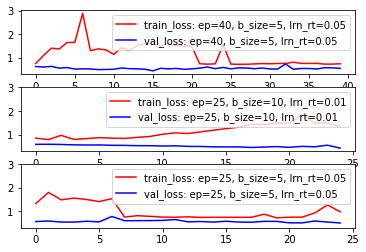


Hyper parameters after tuning:
Number of epochs:25
Learning rate:0.01
Batch size:10

Testing on the best model...

Accuracy and loss for train dataset:
Accuracy: 84.23%, Avg loss: 0.407196
accuracy for class Liberal:                 87.63%
accuracy for class Conservative:                 77.92%

Accuracy and loss for validation dataset:
Accuracy: 81.29%, Avg loss: 0.459166
accuracy for class Liberal:                 84.54%
accuracy for class Conservative:                 75.57%

Accuracy and loss for test dataset:
Accuracy: 83.66%, Avg loss: 0.464136
accuracy for class Liberal:                 88.84%
accuracy for class Conservative:                 74.23%

Time taken: 63.09573841094971
Done!


In [8]:
cf_matrix = run_classifier(4, [128, 128])

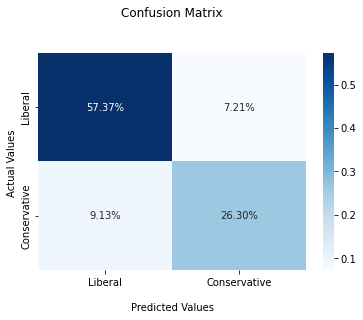

In [9]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Liberal','Conservative'])
ax.yaxis.set_ticklabels(['Liberal','Conservative'])

## Display the visualization of the Confusion Matrix.
plt.show()